## 包络谱

### 1

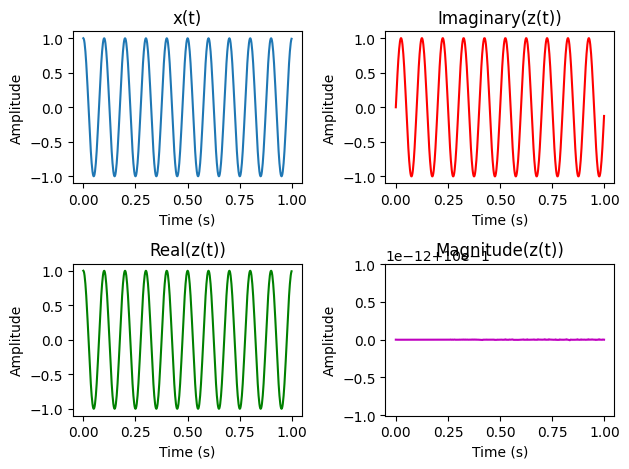

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def analytic_signal(x):
    # 计算解析信号
    X = np.fft.fft(x)
    N = len(X)
    H = np.zeros(N)
    if N % 2 == 0:
        # 偶数个点的情况
        H[0] = H[N//2] = 1
        H[1:N//2] = 2
    else:
        # 奇数个点的情况
        H[0] = 1
        H[1:(N+1)//2] = 2
    Y = X * H
    y = np.fft.ifft(Y)
    return y

# 构造一个正弦波信号
A = 1
f0 = 10
fs = 50*f0
t = np.arange(0, 10/f0, 1/fs)
x = A*np.cos(2*np.pi*f0*t)

# 计算解析信号
z = analytic_signal(x)

# 绘制信号和解析信号的实部和虚部
plt.subplot(221)
plt.plot(t, x)
plt.title('x(t)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.subplot(222)
plt.plot(t, np.imag(z), 'r')
plt.title('Imaginary(z(t))')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.subplot(223)
plt.plot(t, np.real(z), 'g')
plt.title('Real(z(t))')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.subplot(224)
plt.plot(t, np.abs(z), 'm')
plt.title('Magnitude(z(t))')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

### from torchhht

In [36]:
import torch
from torch import nn

def hilbert(x):
    '''
        Perform Hilbert transform along the last axis of x.
        
        Parameters:
        -------------
        x (Tensor) : The signal data. 
                     The Hilbert transform is performed along last dimension of `x`.
        
        Returns:
        -------------
        analytic (Tensor): A complex tensor with the same shape of `x`,
                           representing its analytic signal. 
            
    '''
    x = torch.as_tensor(x).double()
    
    N = x.shape[-1]
    Xf = torch.fft.fft(x)
    if (N % 2 == 0):
        Xf[..., 1 : N//2] *= 2
        Xf[..., N//2+1 : ] = 0
    else:
        Xf[..., 1 : (N+1)//2] *= 2
        Xf[..., (N+1)//2 : ] = 0
    return torch.fft.ifft(Xf)

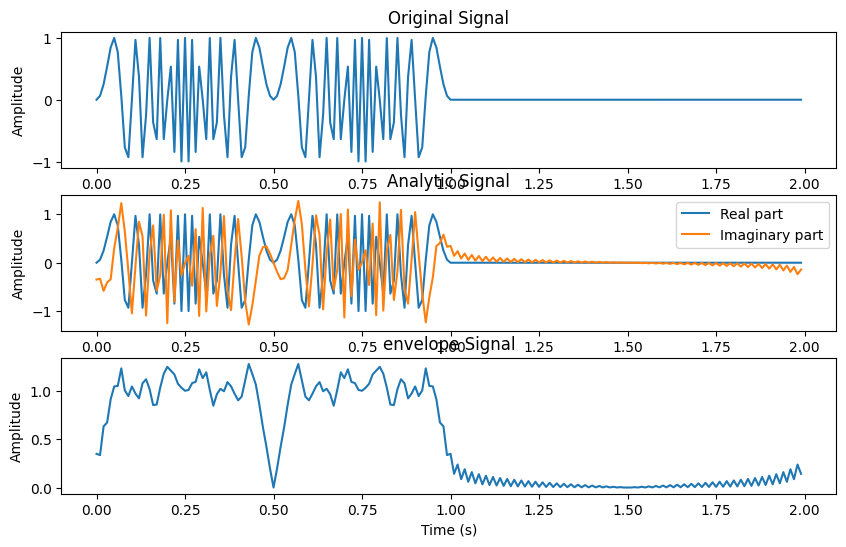

In [45]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 生成调频信号
fs = 100
t = torch.arange(0, 2, 1/fs)
freq = 100 + (t*100).clamp(max=100)
x = torch.sin(2*np.pi*freq*t)

# 对信号进行Hilbert变换
analytic = hilbert(x)
envelope = analytic.abs()

# 绘制原始信号和解析信号
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
axs[0].plot(t, x)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[1].plot(t, analytic.real, label='Real part')
axs[1].plot(t, analytic.imag, label='Imaginary part')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Analytic Signal')
axs[1].legend()


axs[2].plot(t, envelope)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('envelope Signal')
plt.show()

## morlet 小波频谱


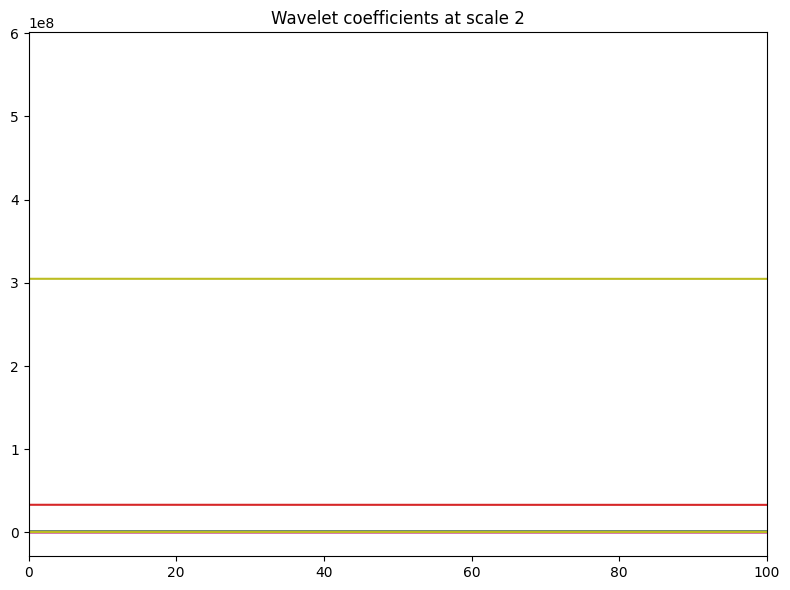

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# 构造一个测试信号
N = 2048
t = np.linspace(0, 1, N, endpoint=False)
sig = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t)

# 小波分解
wavelet = pywt.ContinuousWavelet('cgau3')  # 选择Laplace小波
c = pywt.cwt(sig, scales=np.arange(1, 200), wavelet=wavelet)

# 绘制小波系数对应的频谱
plt.figure(figsize=(8, 6))
for i in range(len(c)):
    fft_c = np.fft.fft(c[i])
    freqs = np.fft.fftfreq(len(c[i])) * N
    plt.plot(freqs[:N//2], abs(fft_c[:N//2])**2)
    plt.xlim(0, 100)
    plt.title('Wavelet coefficients at scale {}'.format(i+1))
plt.tight_layout()
plt.show()

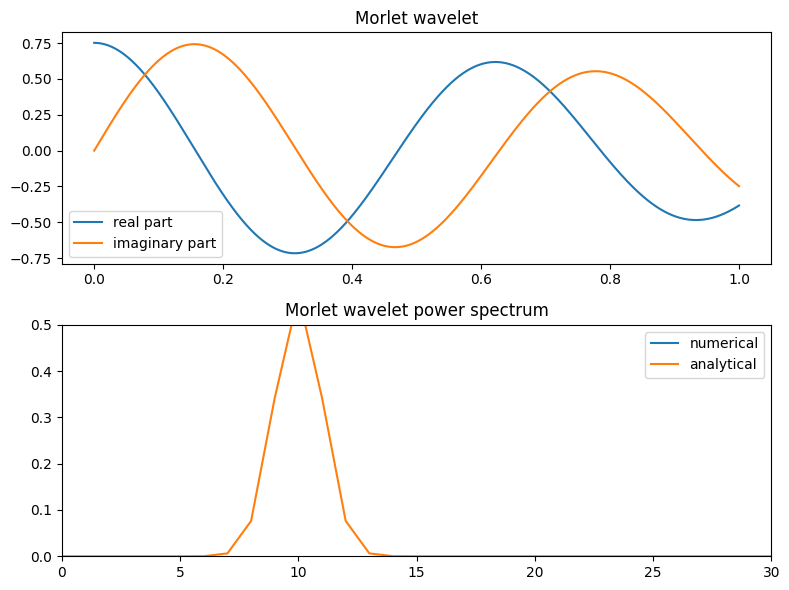

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 构造一个测试信号
N = 20480
t = np.linspace(0, 1, N, endpoint=False) 
sig = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t)

# Morlet小波函数和频谱
def morlet(t, w0):
    """Morlet小波
    
    参数:
    t (array): 时间序列
    w0 (float): 频率
    
    返回:
    (array): $t$ 时刻下对应的Morlet小波值
    """
    return np.pi ** (-0.25) * np.exp(1j * w0 * t) * np.exp(-0.5 * t ** 2)

def morlet_power_spectrum(w, w0):
    """Morlet小波的频谱
    
    参数:
    w (array): 频率序列
    w0 (float): 频率
    
    返回:
    (array): 与输入频率序列相对应的Morlet小波频谱
    """
    return np.pi ** (-0.5) * np.exp(-0.5 * (w - w0) ** 2)

# 绘制Morlet小波及其功率谱
w0 = 10  # 频率选择
dt = t[1] - t[0]
freqs = np.fft.fftfreq(N, dt)
mor = morlet(t, w0)
pow_spec = np.abs(np.fft.fft(mor)) ** 2

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(t, np.real(mor), label='real part')
ax[0].plot(t, np.imag(mor), label='imaginary part')
ax[0].legend()
ax[0].set_title('Morlet wavelet')

ax[1].plot(freqs[:N//2], pow_spec[:N//2], label='numerical')
ax[1].plot(freqs[:N//2], morlet_power_spectrum(freqs[:N//2], w0), label='analytical')
ax[1].set_xlim(0, 30)
ax[1].set_ylim(0, 0.5)
ax[1].legend()
ax[1].set_title('Morlet wavelet power spectrum')
plt.tight_layout()
plt.show()

## 1 simulation

/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


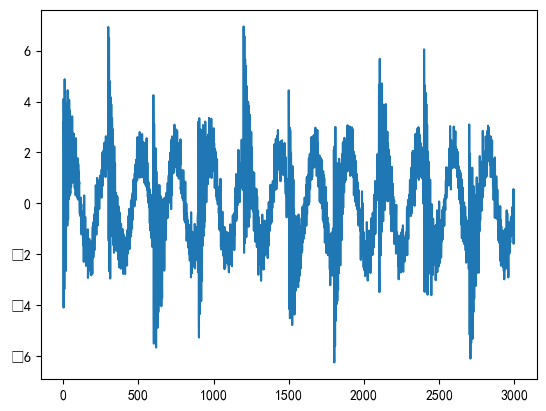

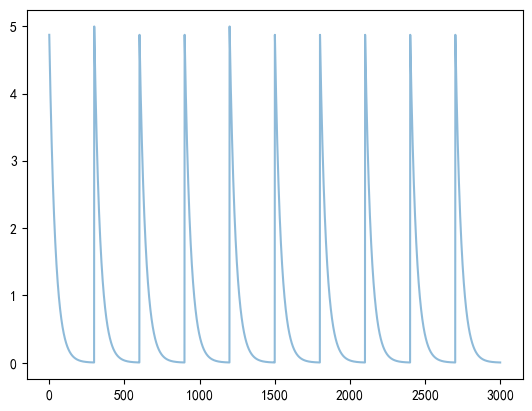

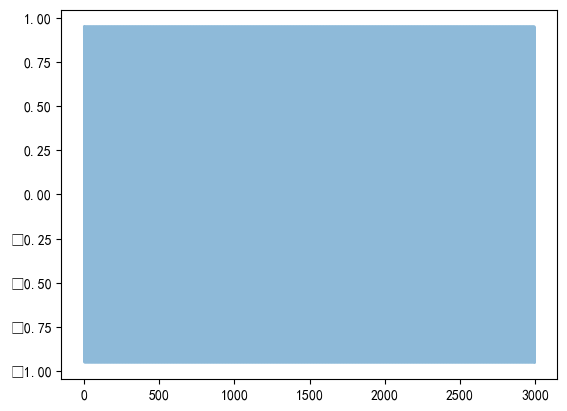

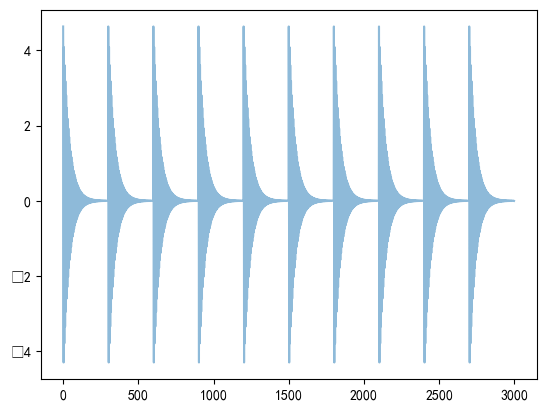

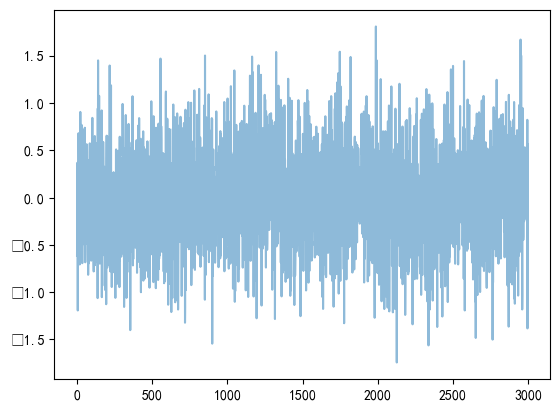

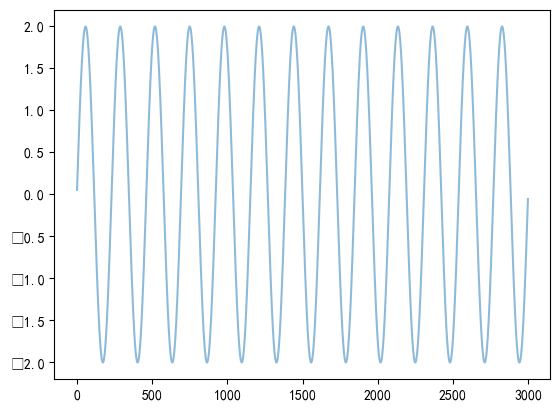

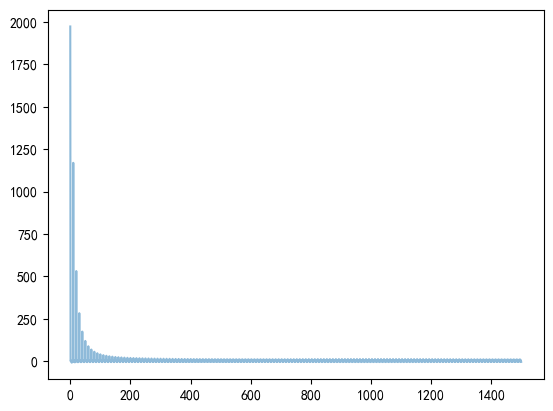

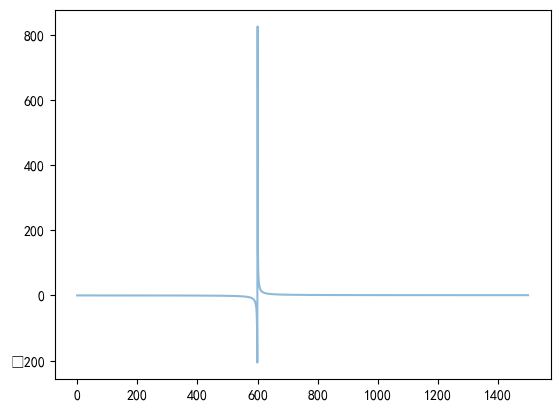

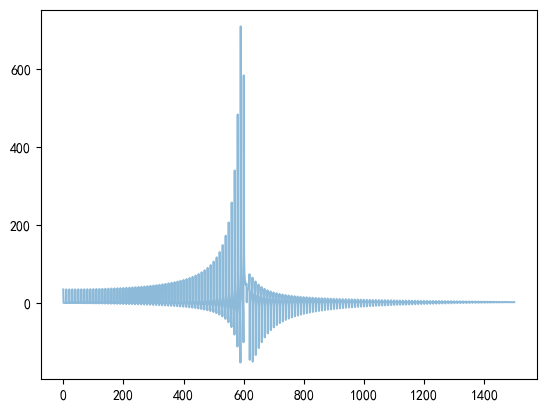

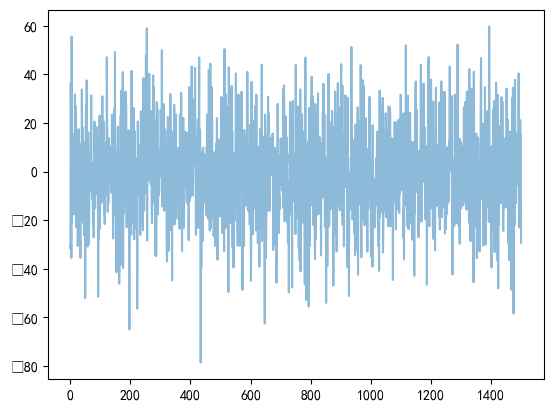

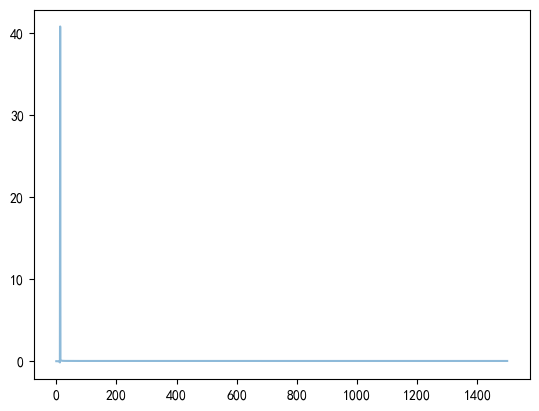

In [2]:
from inspect import signature
import torch
from torch import nn

import torch
import numpy as np
import math
import matplotlib.pyplot as plt
class bearing_signal_simulation():
    """
        original matlab parameter
        fs = 3e3
        t = np.arange(1/fs, 2, 1/fs)# /fs
        fr = 600;                       #% Carrier signal
        fd = 13;                        #% discrete signal
        ff = 10;                        #% Characteristic frequency(Modulating signal)
        a = 0.02;                       #% Damping ratio
        T = 1/ff;                       #% Cyclic period
        fs = 3e3;                       #% Sampling rate
        K = 1;                         #% Number of impulse signal
        K = np.linspace(0,50,5999)
        t = [1/fs:1/fs:2]                #% Time
        A=5;                            #% Maximum amplitude    
        noise = 0.5
    """
    def __init__(
        self,fs = 3e3,time = 2,fr = 600,fd = 13,
        ff = 10,damping_ratio = 0.02,K = 50,A = 5,noise = 0.5
    ):
        self.t = np.arange(1/fs, time, 1/fs)
        self.K = np.linspace(0,K,len(self.t))
        self.t_impact = np.mod(self.t,1/ff)
        self.fs = fs
        self.A = A
        self.fr = fr
        self.fd = fd
        self.ff = ff
        self.damping_ratio = damping_ratio
        self.noise = noise
        self.signal_generatator()
    def signal_generatator(self):        
        self.x1 = self.A*np.exp(-self.damping_ratio*2*math.pi*self.fr*(self.t_impact))
        self.x2 = np.sin(2*math.pi*self.fr*(self.t))
        self.x3 = self.x1*self.x2
        self.x4 = np.random.normal(0,self.noise,len(self.x3))
        self.x5 = 2*np.sin(2*math.pi*self.t*self.fd)
        self.vib = self.x3+self.x4+self.x5
        return self.vib
    def signal_plot(self,signal = 'vib'):
        plt.figure()
        plt.plot(self.vib,label = 'vib')
bearing1 = bearing_signal_simulation(fs = 3e3,time = 1,fr = 600,
    fd = 13,ff = 10,damping_ratio = 0.02,K = 50,A = 5,noise = 0.5)   
bearing1.signal_plot()
plt.figure()
plt.plot(bearing1.x1,label = 'x1',alpha = 0.5)
plt.figure()
plt.plot(bearing1.x2,label = 'x2',alpha = 0.5)
plt.figure()
plt.plot(bearing1.x3,label = 'x3',alpha = 0.5)
plt.figure()
plt.plot(bearing1.x4,label = 'x4',alpha = 0.5)
plt.figure()
plt.plot(bearing1.x5,label = 'x5',alpha = 0.5)

plt.figure()
plt.plot(np.fft.rfft(bearing1.x1),label = 'x1',alpha = 0.5)
plt.figure()
plt.plot(np.fft.rfft(bearing1.x2),label = 'x2',alpha = 0.5)
plt.figure()
plt.plot(np.fft.rfft(bearing1.x3),label = 'x3',alpha = 0.5)
plt.figure()
plt.plot(np.fft.rfft(bearing1.x4),label = 'x4',alpha = 0.5)
plt.figure()
plt.plot(np.fft.rfft(bearing1.x5),label = 'x5',alpha = 0.5)



## 频谱和包络谱

/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


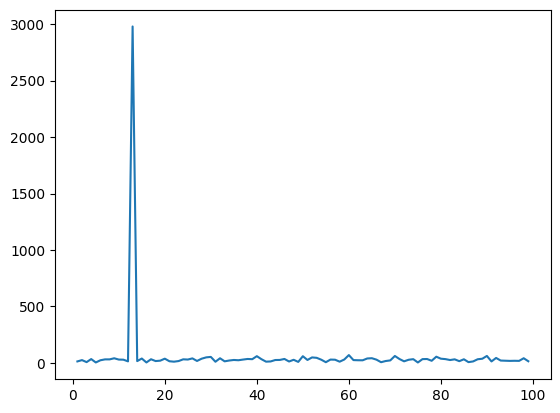

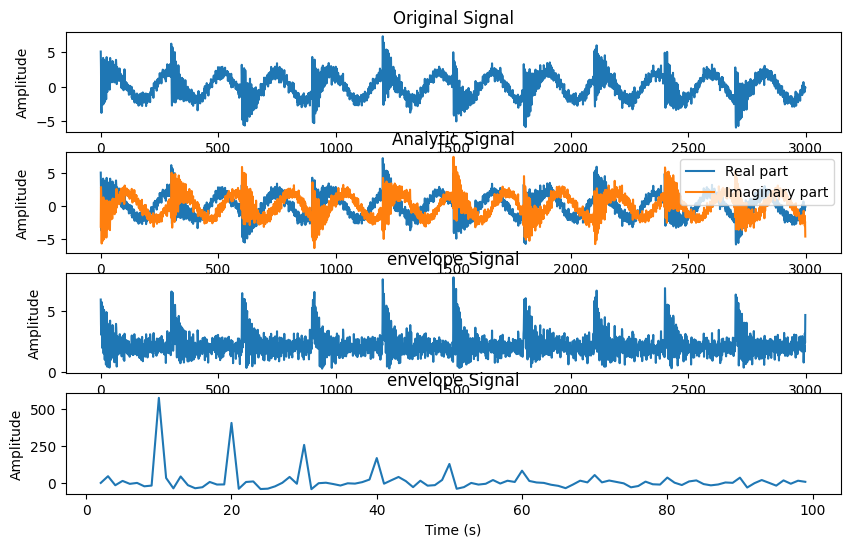

In [147]:
f = torch.arange(3e3*1-1) 
vib_fre = np.abs(np.fft.fft(bearing1.vib)) 
plt.plot(f[1:100],vib_fre[1:100],label = 'fre')

# 对信号进行Hilbert变换
x = bearing1.vib
analytic = hilbert(x)
envelope = analytic.abs()
t = f
# 绘制原始信号和解析信号
fig, axs = plt.subplots(4, 1, figsize=(10, 6))
axs[0].plot(t, x)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Original Signal')
axs[1].plot(t, analytic.real, label='Real part')
axs[1].plot(t, analytic.imag, label='Imaginary part')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Analytic Signal')
axs[1].legend()


axs[2].plot(t, envelope)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('envelope Signal')

envfft = np.fft.fft(envelope)
axs[3].plot(t[2:100], envfft[2:100])
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('envelope Signal')
plt.show()

## 频域算子

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


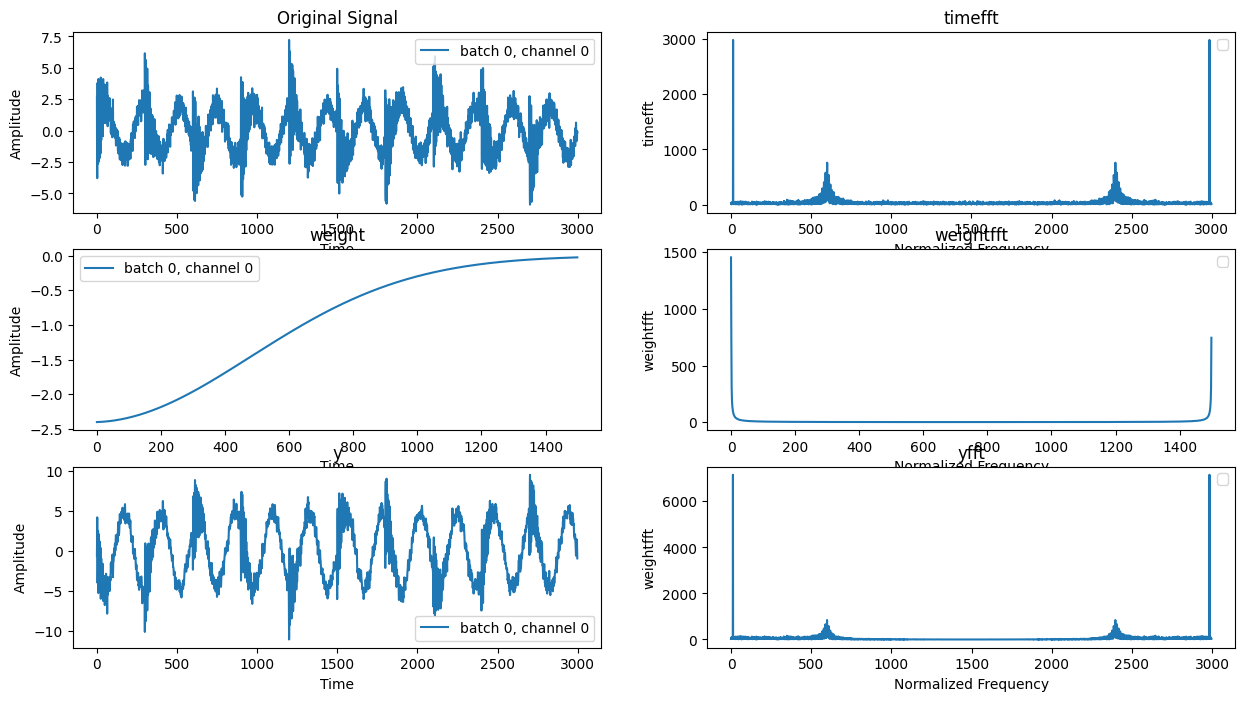

In [162]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import math
class frequency_operation(nn.Module):
    def __init__(self, mu=0.1, sigma=1,
                 length=1024, fs = 25600,
                 type = 'normal'
                 ) -> None:
        super().__init__()
        
        self.mu = nn.Parameter(torch.Tensor([mu]))
        self.sigma = nn.Parameter(torch.Tensor([sigma]))
        self.length = length//2 if length//2 == 0 else length//2 +1
        self.x = torch.linspace(0, 0.5, self.length)    # 0-0.5的归一化频率范围
        
        nn.init.normal_(self.mu,std=0.1)
        nn.init.normal_(self.sigma,std=0.1)
        
        if type == 'normal':
            self.weight = self.normal()
        elif type == 'sinc':
            self.weight = self.sinc()
        
    def normal(self):
        shift = self.x - self.mu
        normal = torch.exp(-0.5 * ((shift) / self.sigma) ** 2) / (self.sigma * math.sqrt(2 * torch.pi))
        return normal
    
    def sinc(self):
        shift = self.x/self.sigma - self.mu
        sinc = torch.sin(shift)/(shift+1e-12)     
        return sinc  
    
    def forward(self,x):
        # b,c,l
        c,lenth,device = *x.shape[-2:],x.device
        x = torch.fft.rfft(x, dim=2, norm='ortho') # 

        x =  x * self.weight
        x = torch.fft.irfft(x, dim=2, norm='ortho')
        x = x.view(-1, c, lenth).real
        return x        

# 生成测试数据
b, c, l = 1, 1, 1024
# x = torch.randn((b, c, l))
x = torch.Tensor(bearing1.vib[1:]).view(b, c, -1)
l = len(bearing1.vib)
# 构建频率操作模块
freq_op = frequency_operation(mu=0.1, sigma=0.1, length=l, fs=25600, type='normal')

# 获取weight
weight = freq_op.weight

# 对输入信号进行操作
y = freq_op(x)

# 绘制图像
fig, axs = plt.subplots(3, 2, figsize=(15, 8))
# x = x
# 绘制原始信号的时域图像
for i in range(b):
    for j in range(c):
        time = x
        weight = freq_op.weight.detach().cpu().numpy().squeeze()
        y = freq_op(time).detach().cpu().numpy().squeeze()
        time = time.detach().cpu().numpy().squeeze()
        
        timefft = np.fft.fft(time)
        weightfft = np.fft.fft(weight)
        yfft = np.fft.fft(y)
        
        timefft = np.abs(timefft).squeeze()
        weightfft = np.abs(weightfft).squeeze()
        yfft = np.abs(yfft).squeeze()
        
        axs[0, 0].plot(time, label=f'batch {i}, channel {j}')
        axs[0, 0].set_xlabel('Time')
        axs[0, 0].set_ylabel('Amplitude')
        axs[0, 0].set_title('Original Signal')
        axs[0, 0].legend()


        axs[0, 1].plot(timefft)
        axs[0, 1].set_xlabel('Normalized Frequency')
        axs[0, 1].set_ylabel('timefft')
        axs[0, 1].set_title('timefft')
        axs[0, 1].legend()
###############################
        axs[1, 0].plot(weight, label=f'batch {i}, channel {j}')
        axs[1, 0].set_xlabel('Time')
        axs[1, 0].set_ylabel('Amplitude')
        axs[1, 0].set_title('weight')
        axs[1, 0].legend()


        axs[1, 1].plot(weightfft)
        axs[1, 1].set_xlabel('Normalized Frequency')
        axs[1, 1].set_ylabel('weightfft')
        axs[1, 1].set_title('weightfft')
        axs[1, 1].legend()
###############################
        axs[2, 0].plot(y, label=f'batch {i}, channel {j}')
        axs[2, 0].set_xlabel('Time')
        axs[2, 0].set_ylabel('Amplitude')
        axs[2, 0].set_title('y')
        axs[2, 0].legend()


        axs[2, 1].plot(yfft[1:])
        axs[2, 1].set_xlabel('Normalized Frequency')
        axs[2, 1].set_ylabel('weightfft')
        axs[2, 1].set_title('yfft')
        axs[2, 1].legend()

        plt.show()

### sinc

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


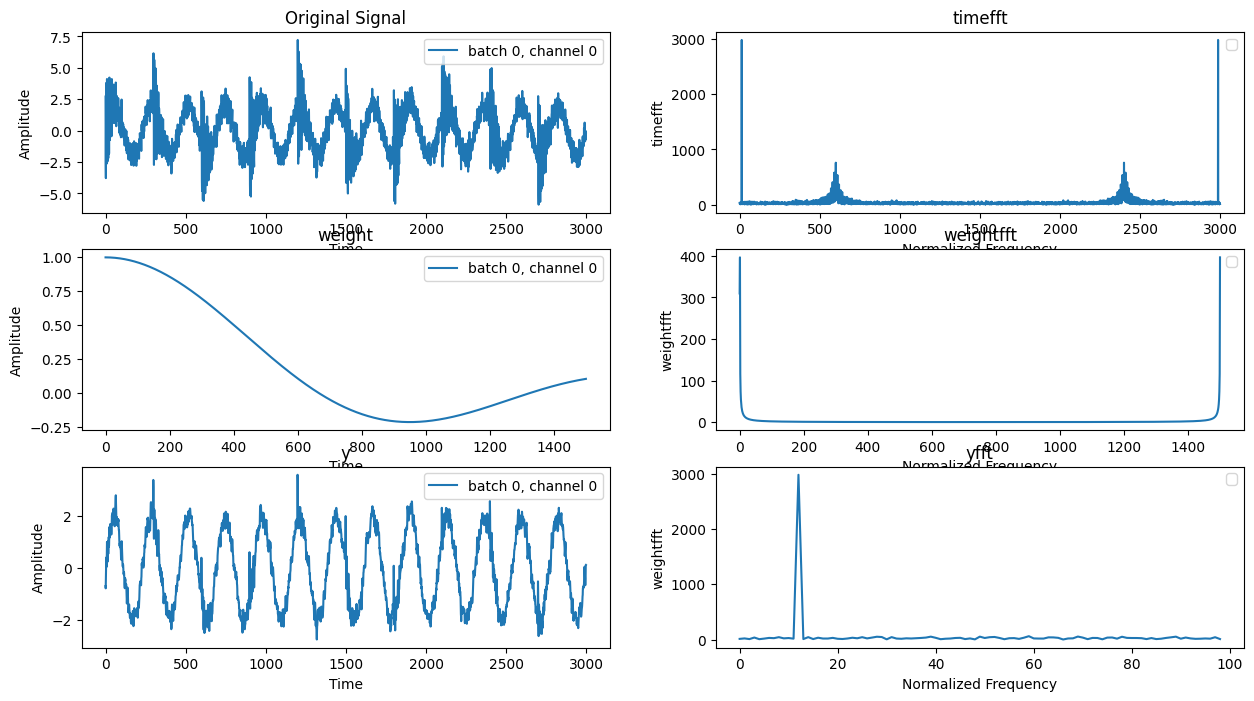

In [169]:
b, c, l = 1, 1, 1024
# x = torch.randn((b, c, l))
x = torch.Tensor(bearing1.vib[1:]).view(b, c, -1)
l = len(bearing1.vib)
# 构建频率操作模块
freq_op = frequency_operation(mu=0.1, sigma=0.1, length=l, fs=25600, type='sinc')

# 获取weight
weight = freq_op.weight

# 对输入信号进行操作
y = freq_op(x)

# 绘制图像
fig, axs = plt.subplots(3, 2, figsize=(15, 8))
# x = x
# 绘制原始信号的时域图像
for i in range(b):
    for j in range(c):
        time = x
        weight = freq_op.weight.detach().cpu().numpy().squeeze()
        y = freq_op(time).detach().cpu().numpy().squeeze()
        time = time.detach().cpu().numpy().squeeze()
        
        timefft = np.fft.fft(time)
        weightfft = np.fft.fft(weight)
        yfft = np.fft.fft(y)
        
        timefft = np.abs(timefft).squeeze()
        weightfft = np.abs(weightfft).squeeze()
        yfft = np.abs(yfft).squeeze()
        
        axs[0, 0].plot(time, label=f'batch {i}, channel {j}')
        axs[0, 0].set_xlabel('Time')
        axs[0, 0].set_ylabel('Amplitude')
        axs[0, 0].set_title('Original Signal')
        axs[0, 0].legend()


        axs[0, 1].plot(timefft)
        axs[0, 1].set_xlabel('Normalized Frequency')
        axs[0, 1].set_ylabel('timefft')
        axs[0, 1].set_title('timefft')
        axs[0, 1].legend()
###############################
        axs[1, 0].plot(weight, label=f'batch {i}, channel {j}')
        axs[1, 0].set_xlabel('Time')
        axs[1, 0].set_ylabel('Amplitude')
        axs[1, 0].set_title('weight')
        axs[1, 0].legend()


        axs[1, 1].plot(weightfft)
        axs[1, 1].set_xlabel('Normalized Frequency')
        axs[1, 1].set_ylabel('weightfft')
        axs[1, 1].set_title('weightfft')
        axs[1, 1].legend()
###############################
        axs[2, 0].plot(y, label=f'batch {i}, channel {j}')
        axs[2, 0].set_xlabel('Time')
        axs[2, 0].set_ylabel('Amplitude')
        axs[2, 0].set_title('y')
        axs[2, 0].legend()


        axs[2, 1].plot(yfft[1:100])
        axs[2, 1].set_xlabel('Normalized Frequency')
        axs[2, 1].set_ylabel('weightfft')
        axs[2, 1].set_title('yfft')
        axs[2, 1].legend()

        plt.show()

## numpy 的小波

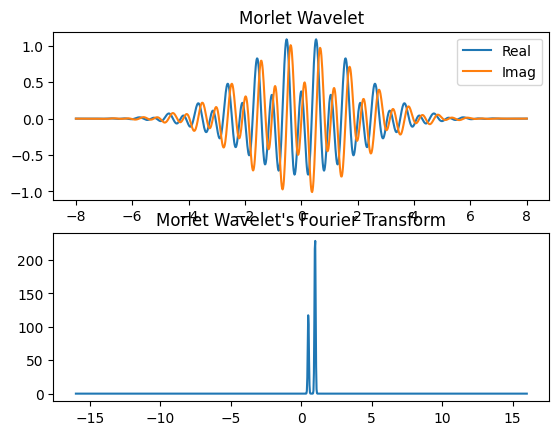

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义Morlet小波函数
def morlet(t, omega0=6, sigma=2, k=0.5):
    return np.pi**(-1/4) * np.exp(1j*omega0*t) * np.exp(-t**2/(2*sigma**2)) * (np.exp(1j*omega0*t) - k)

# 定义Morlet小波函数的傅里叶变换
def morlet_fft(omega, omega0=6, sigma=2, k=0.5):
    A = sigma * np.sqrt(np.pi)
    B = (np.exp(-(omega - omega0)**2/(2*sigma**2))) #- k*np.exp(-omega0**2/2*sigma**2)
    return A * B

# 绘制Morlet小波函数及其傅里叶变换
t = np.linspace(-8, 8, 1024)
f = np.linspace(-16, 16, 1024)
mor = morlet(t)
mor_fft = np.abs(np.fft.fftshift(np.fft.fft(mor)))

plt.subplot(211)
plt.plot(t, np.real(mor), label='Real')
plt.plot(t, np.imag(mor), label='Imag')
plt.legend()
plt.title('Morlet Wavelet')

plt.subplot(212)
plt.plot(f, mor_fft)
plt.title('Morlet Wavelet\'s Fourier Transform')
plt.show()

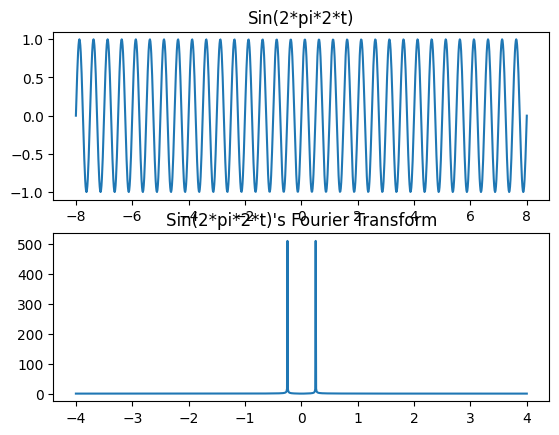

/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 35889 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 21253 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 32476 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/richie_thu/minicon

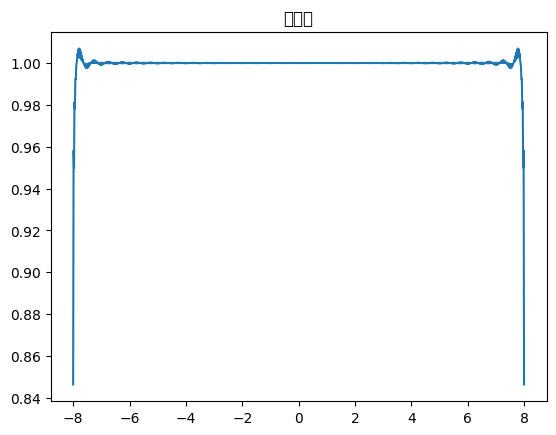

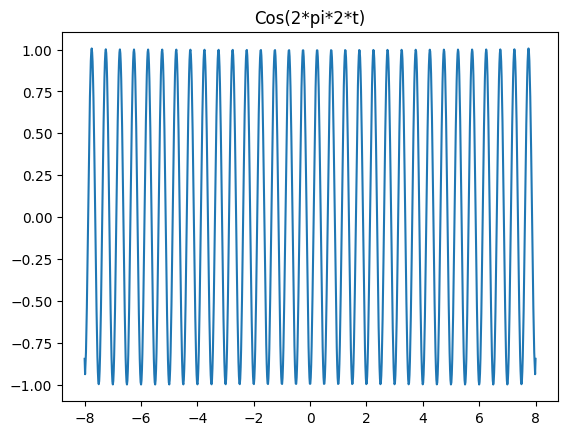

In [14]:
sinx = np.sin(2*np.pi*2*t)
f = np.linspace(-4, 4, 1024)
fft = np.fft.fft(sinx)


    
sinx_fft = np.abs(np.fft.fftshift(fft))
plt.subplot(211)
plt.plot(t, sinx)
plt.title('Sin(2*pi*2*t)')
plt.subplot(212)
plt.plot(f, sinx_fft)
plt.title('Sin(2*pi*2*t)\'s Fourier Transform')
plt.show()

N = sinx.shape[-1]
if (N % 2 == 0):
    fft[..., 1 : N//2] *= 2
    fft[..., N//2+1 : ] = 0
else:
    fft[..., 1 : (N+1)//2] *= 2
    fft[..., (N+1)//2 : ] = 0
    
cosx = np.fft.ifft(fft)
plt.plot(t, np.abs(cosx))
plt.title('包络谱')
plt.show()
plt.plot(t, cosx.imag)
plt.title('Cos(2*pi*2*t)')
plt.show()

## 降采样

In [8]:
import torch
x = torch.randn(1, 1, 1024)
downsample = torch.nn.AvgPool1d(kernel_size=2, stride=2)
y = x[:,:,::2]
y_downsample = downsample(x)
y_downsample2 = downsample(y)

In [3]:
import torch
def norm(x):
    mean = x.mean(dim = 1,keepdim = True)
    std = x.std(dim = 1,keepdim = True)
    out = (x-mean)/(std + 1e-10)
    return out

x = torch.Tensor([[[1,2,3,4,5,6,7,8,9,10],[3,2,3,4,5,6,7,8,9,10]]])
print(x.shape)

torch.Size([1, 2, 10])


/home/richie_thu/miniconda3/envs/TS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
norm(x)

tensor([[[-0.7071,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.7071,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000]]])

# test sincnet

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

def sinc(band, t_right):
    y_right = torch.sin(2 * math.pi * band * t_right) / (2 * math.pi * band * t_right)
    y_left = torch.flip(y_right, [0])
    y = torch.cat([y_left, torch.ones(1).to(t_right.device), y_right])
    return y

class SincConv_fast(nn.Module):
    def __init__(self, out_channels, kernel_size, in_channels=1):
        super().__init__()

        if in_channels != 1:
            raise ValueError(f"SincConv only supports one input channel (here, in_channels = {in_channels})")

        self.out_channels = out_channels
        self.kernel_size = kernel_size

        if kernel_size % 2 == 0:
            self.kernel_size += 1

        self.a_ = nn.Parameter(torch.linspace(1, 10, out_channels)).view(-1, 1)
        self.b_ = nn.Parameter(torch.linspace(0, 10, out_channels)).view(-1, 1)

    def forward(self, waveforms):
        half_kernel = self.kernel_size // 2
        time_disc = torch.linspace(-half_kernel, half_kernel, steps=self.kernel_size).to(waveforms.device)

        filters = []
        for i in range(self.out_channels):
            band = self.a_[i]
            t_right = time_disc - self.b_[i]
            filter = sinc(band, t_right)
            filters.append(filter)

        filters = torch.stack(filters)
        self.filters = filters.view(self.out_channels, 1, -1)

        return F.conv1d(waveforms, self.filters, stride=1, padding=half_kernel, dilation=1, bias=None, groups=1)

# 测试代码
if __name__ == "__main__":
    batch_size = 10
    channels = 1
    length = 1024
    num_classes = 5
    kernel_size = 62  # 假设的核大小

    x = torch.randn(batch_size, channels, length)
    model = SincConv_fast(out_channels=num_classes, kernel_size=kernel_size)
    output = model(x)

    print("Output shape:", output.shape)


Output shape: torch.Size([10, 5, 960])


In [8]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x1(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = conv3x1(planes, planes, stride)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm1d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
class SincNet(nn.Module):

    def __init__(self, block, layers, in_channel=1, num_class=4, zero_init_residual=False, Wave_first = True):
        super(SincNet, self).__init__()
        self.inplanes = 64


        
        self.conv1 = SincConv_fast(64, 16)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, num_class)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
if __name__ == "__main__":
    batch_size = 10
    channels = 1
    length = 1024
    num_classes = 5
    kernel_size = 62  # 假设的核大小

    x = torch.randn(batch_size, channels, length)
    model = SincNet(BasicBlock, [2, 2, 2, 2], in_channel=1, num_class=4, Wave_first = True)
    output = model(x)

    print("Output shape:", output.shape)

NameError: name 'conv3x1' is not defined

##